#  Basic usage tutorial 

## Installation in Unix

  - conda installation. Type in your console the following command:   
    ```bash
     wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
    ```

  - Then add miniconda to your path
    ```bash
     ./miniconda.sh -b -p $HOME/miniconda
    ```

  - Create new virtual environment
    ```bash
     conda create -q -n qmflows python=3.5
    ```

  - Install dependecies
    ```bash 
     conda install --name qmflows -c anaconda hdf5
     conda install --name qmflows -c https://conda.anaconda.org/rdkit rdkit
    ```

  - Start environment
    ```bash
     source activate qmflows
    ```

  - install **qmflows** dependencies
    ```bash
     pip install https://github.com/SCM-NV/qmflows/tarball/master#egg=qmflows https://github.com/SCM-NV/plams/tarball/master#egg=plams --upgrade
    ```
### You are ready to start!

## Starting the environment
Once *QMflows*  has been installed the user should run the following command to initialize the environment:

```bash
[user@int1 ~]$ source activate qmflows
discarding /home/user/anaconda3/bin from PATH
prepending /home/user/anaconda3/envs/qmflows/bin to PATH
(qmflows)[user@int1 ~]$ python --version
Python 3.5.2 :: Anaconda custom (64-bit)
```

To leave the environment the following command is used

```bash
(qmflows)[user@int1 ~]$ source deactivate
discarding /home/user/anaconda3/envs/qmflows/bin from PATH
```

To finalize preparations before running QMflows: if you don't want the results  to end up in the current work directory, create a new results folder.

In [26]:
mkdir tutorial_results

 What is QMflows?
QMflows is a python library that enables executing complicated workflows of interdependent quantum chemical (QM) calculations in python. It aims at providing a common interface to multiple QM packages, enabling easy and systematic generation of the calculation inputs, as well as facilitating automatic analysis of the results. Furthermore it is build on top of the powerful Noodles framework for executing the calculations in parallel where possible.

## The basics: calling packages
Currently **QMFLOWS** offers an interface with the following simulation software:

* **SCM (ADF and DTFB)**
* **CP2K**
* **ORCA**
* **GAMESS-US**
* **DIRAC**

 *Please make sure that the packages you want to use in QMflows are installed and active; in most supercomputer the simulation package are available using a command like (consult your system administrator):*

```bash
 load module superAwesomeQuantumPackage/3.1421
```

*Also some simulation packages required that you configure a `scratch` folder. For instance *Orca* requires a `SCR` folder to be defnied while *ADF*  called it `SCM_TMPDIR`.*


With ``qmflows`` you can write a python script that simply calls one of the package objects 
`adf, dftb, cp2k, orca, gamess or dirac`.
As arguments to the call, you need to provide a ``settings`` objects defining the input of a calculation, a molecular geometry, and, optionally, a job name that enables you to find back the "raw" data of the calculation later on.

Let's see how this works:

First we define a molecule, for example by reading one from an xyz file:

In [27]:
from plams import Molecule
acetonitrile = Molecule("files/acetonitrile.xyz")
print(acetonitrile)

  Atoms: 
    1         C      2.419290      0.606560      0.000000 
    2         C      1.671470      1.829570      0.000000 
    3         N      1.065290      2.809960      0.000000 
    4         H      2.000000      0.000000      1.000000 
    5         H      2.000000      0.000000     -1.000000 
    6         H      3.600000      0.800000      0.000000 



Then we can perform geometry optimization on the molecule by a call to the dftb package object:

In [28]:
from qmflows import dftb, templates, run
job = dftb(templates.geometry, acetonitrile, job_name="dftb_geometry_optimization")
print(job)

As you can see, "job" is a so-called "promised object". It means it first needs to be "run" by the Noodles scheduler to return a normal python object.

In [29]:
result = run(job, path="tutorial_results", folder="run_one", cache="tutorial_cache.json")
print(result)

[09:14:04] PLAMS working folder: /home/lars/workspace/qmflows/jupyterNotebooks/tutorial_results/run_one
╭─(running jobs)
│ Running dftb dftb_geometry_optimization...
╰(✔)─(success)


We can easily retrieve the calculated properties from the DFTB calculation such as the dipole or the optimized geometry for use in subsequent calculations.

In [30]:
print("Dipole: ", result.dipole)
print(result.molecule)

Dipole:  [1.0864213029, -1.9278296041, -0.0]
  Atoms: 
    1         C      2.366998      0.579794     -0.000000 
    2         C      1.660642      1.834189      0.000000 
    3         N      1.089031      2.847969      0.000000 
    4         H      2.100157      0.010030      0.887206 
    5         H      2.100157      0.010030     -0.887206 
    6         H      3.439065      0.764079     -0.000000 



# Settings and templates
In the above example ``templates.geometry`` was actually a predefined Settings object.
You can define and manipulate Settings in a completely flexible manner as will be explained in this section. To facilitate combining different packages in one script, QMflows defines a set of commonly used generic keywords, which can be combined with package specific keywords, to provide maximum flexibility.

In [31]:
from qmflows import Settings
s = Settings()
s.basis = "DZP"
s.specific.adf.basis.core = "large"
s.freeze = [1,2,3]
print(s)

basis: 	DZP
freeze: 	[1, 2, 3]
specific: 	
         adf: 	
             basis: 	
                   core: 	large



This code snippet illustrates that the ``Settings`` can be specified in two ways, using generic or specific keywords. Generic keywords represent input properties that are present in most simulation packages like a *basis set* while *specific* keywords allow the user to apply specific keywords for a package that are not in a generic dictionary.

<font color='red'> Expert info: *Settings* are a subclass of python [dictionaries](https://docs.python.org/3.5/tutorial/datastructures.html#dictionaries) to represent herarchical structures, like
<img src="files/simpleTree.png"> </font>

In QMflows/PLAMS multiple settings objects can be combined using the ``overlay`` function.

In [32]:
merged_settings = templates.geometry.overlay(s)
print(merged_settings)

basis: 	DZP
freeze: 	[1, 2, 3]
specific: 	
         adf: 	
             basis: 	
                   core: 	large
                   type: 	SZ
             geometry: 	
                      optim: 	delocal
             integration: 	
                         accint: 	6.0
             scf: 	
                 converge: 	1e-06
                 iterations: 	100
             xc: 	
                __block_replace: 	True
                lda: 	
         cp2k: 	
              force_eval: 	
                         dft: 	
                             basis_set_file_name: 	
                             mgrid: 	
                                   cutoff: 	400
                                   ngrids: 	4
                             potential_file_name: 	
                             qs: 	
                                method: 	gpw
                             scf: 	
                                 OT: 	
                                    N_DIIS: 	7
                                    minimizer

The *overlay* method merged the template containing default settings for geometry optimizations with different packages with the arguments provided by the user 


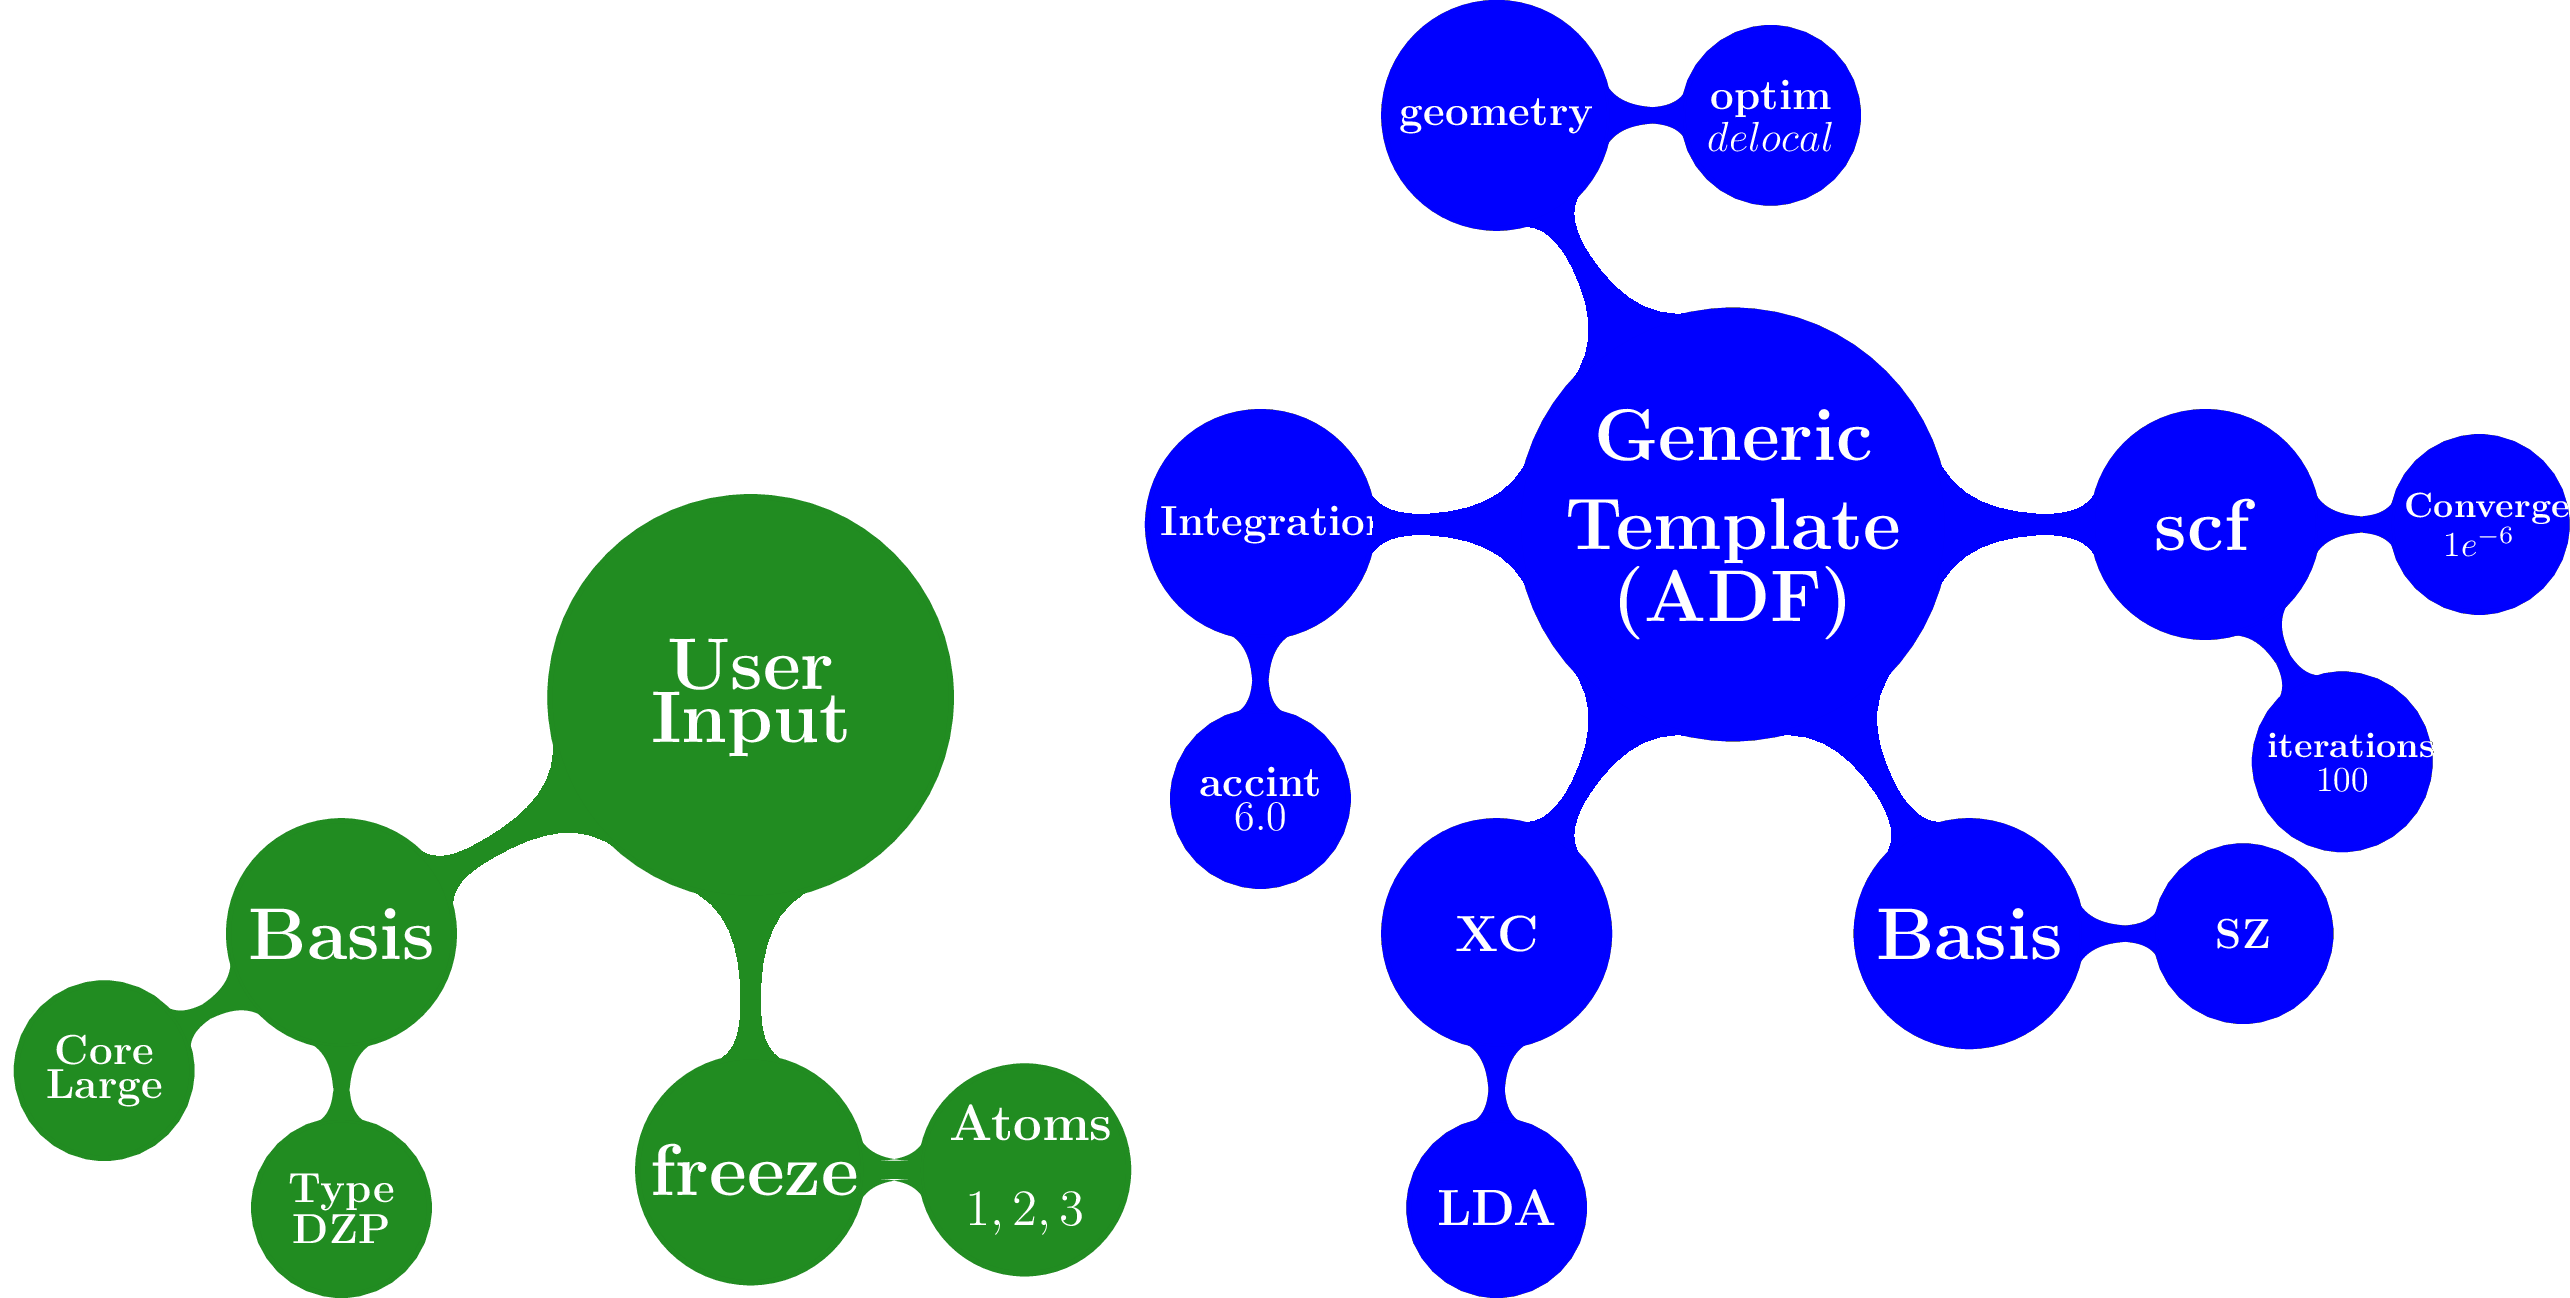

In [4]:
from IPython.display import display, Image
Image(filename="files/merged.png")

**resulting in:**

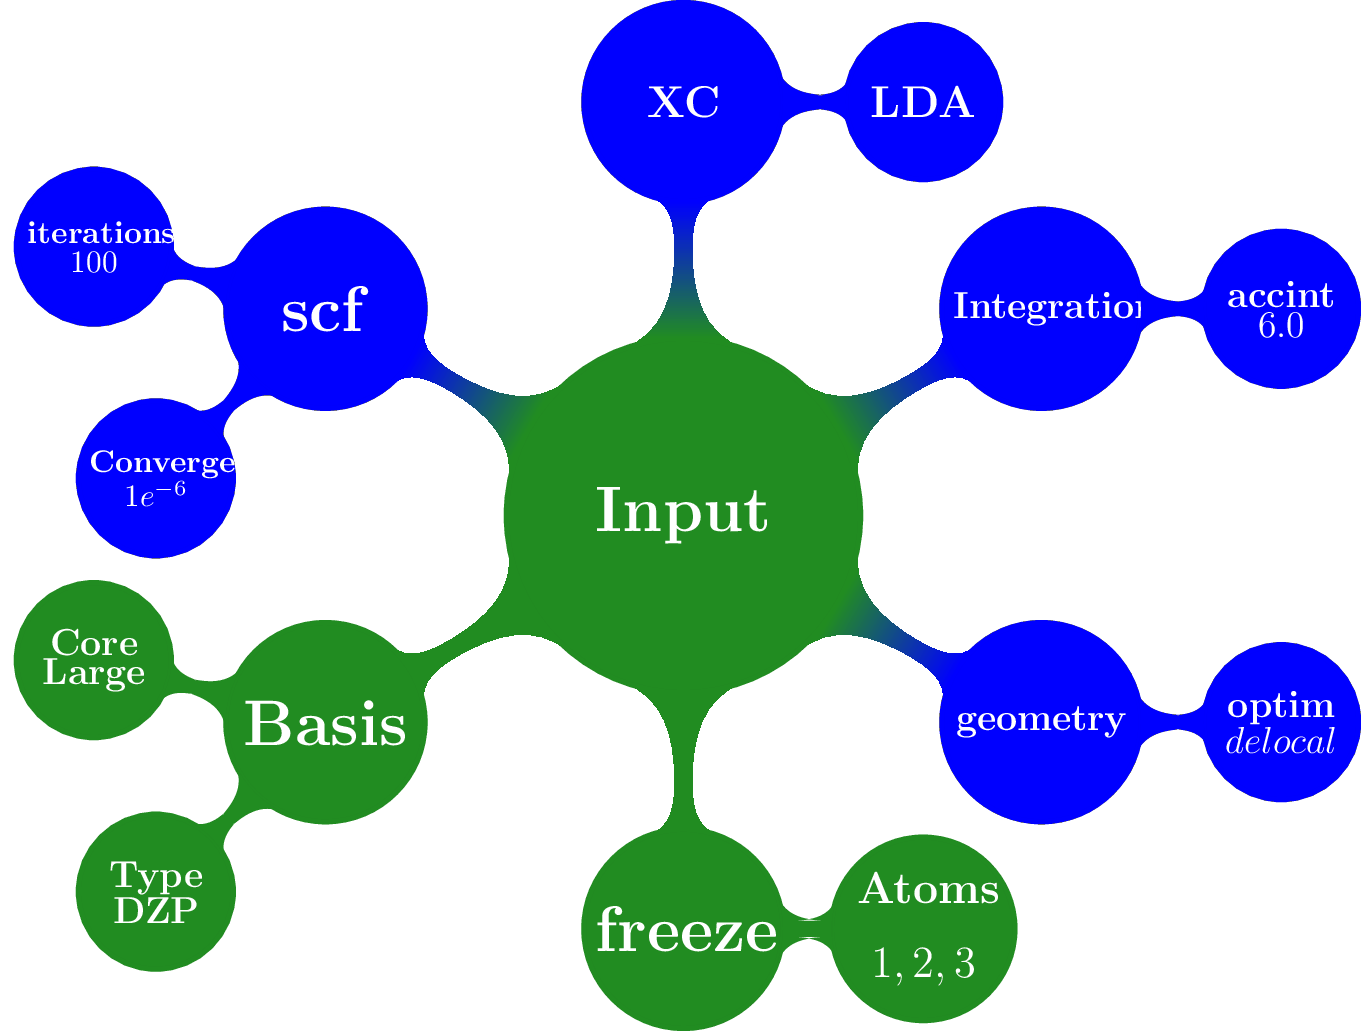

In [3]:

Image(filename="files/result_merged.png")

Note that the generic and specific keywords still exist next to each other and may not be consistent (e.g. different basis sets are defined in generic and specific keywords). Upon calling a package with a Settings object, the generic keywords are first translated into package specific keywords and combined with the relevant user defined specific keywords. In this step, the settings defined in generic keywords take preference. Subsequently, the input file(s) for the given package is/are generated, based on the keywords after **specific.[package]** based on the [PLAMS software](https://www.scm.com/doc/plams/index.html).


In [33]:
from qmflows import adf
print(adf.generic2specific(merged_settings))

basis: 	DZP
freeze: 	[1, 2, 3]
specific: 	
         adf: 	
             basis: 	
                   core: 	large
                   type: 	DZP
             constraints: 	
                         atom 2: 	
                         atom 3: 	
                         atom 4: 	
             geometry: 	
                      optim: 	cartesian
             integration: 	
                         accint: 	6.0
             scf: 	
                 converge: 	1e-06
                 iterations: 	100
             xc: 	
                __block_replace: 	True
                lda: 	
         cp2k: 	
              force_eval: 	
                         dft: 	
                             basis_set_file_name: 	
                             mgrid: 	
                                   cutoff: 	400
                                   ngrids: 	4
                             potential_file_name: 	
                             qs: 	
                                method: 	gpw
                             sc

In the case of adf the above keywords result in the following input file for ADF package:

In [34]:
adf_job = adf(merged_settings, acetonitrile, job_name='adf_acetonitrile')
result = run(adf_job, path="tutorial_results", 
             folder="run_two", cache="tutorial_cache.json")
print(open('tutorial_results/run_two/adf_acetonitrile/adf_acetonitrile.in').read())

[09:14:04] PLAMS working folder: /home/lars/workspace/qmflows/jupyterNotebooks/tutorial_results/run_two
╭─(running jobs)
│ Running adf adf_acetonitrile...
(✔)╰─(success)
atoms
      1         C      2.419290      0.606560      0.000000 
      2         C      1.671470      1.829570      0.000000 
      3         N      1.065290      2.809960      0.000000 
      4         H      2.000000      0.000000      1.000000 
      5         H      2.000000      0.000000     -1.000000 
      6         H      3.600000      0.800000      0.000000 
end

basis
  core large
  type DZP
end

constraints
  atom 2
  atom 3
  atom 4
end

geometry
  optim cartesian
end

integration
  accint 6.0
end

scf
  converge 1e-06
  iterations 100
end

xc
  lda
end

end input



# Combining multiple jobs 

Multiple jobs can be combined, while calling the run function only once. The script below combines components outlined above:

In [35]:
from plams import Molecule
from qmflows import dftb, adf, templates, run, Settings

acetonitrile = Molecule("files/acetonitrile.xyz")

dftb_opt = dftb(templates.geometry, acetonitrile, job_name="dftb_opt")

s = Settings()
s.basis = "DZP"
s.specific.adf.basis.core = "large"
adf_single = adf(templates.singlepoint.overlay(s), dftb_opt.molecule, job_name="adf_single")

adf_result = run(adf_single, path="tutorial_results", folder="workflow", cache="tutorial_cache.json")
print(adf_result.molecule)
print(adf_result.energy)

[09:15:08] PLAMS working folder: /home/lars/workspace/qmflows/jupyterNotebooks/tutorial_results/workflow
╭─(running jobs)
│ Running dftb dftb_opt...
(✔)│ Running adf adf_single...
(✔)╰─(success)
  Atoms: 
    1         C      0.000000      0.000000      0.656511 
    2         C      0.000000      0.000000     -0.783088 
    3         N      0.000000      0.000000     -1.946913 
    4         H     -0.512221     -0.887193      1.022016 
    5         H      1.024442      0.000000      1.022016 
    6         H     -0.512221      0.887193      1.022016 

-1.4094874734528888


In this case the second task adf_single reads the molecule optimized in the first job dftb_opt. Note that dftb_opt as well as dftb_opt.molecule are promised objects. When **run** is applied to the adf_single job, noodles builds a graph of dependencies and makes sure all the calculations required to obtain **adf_result** are performed.

All data related to the calculations, i.e. input files generated by QMflows and the resulting output files generated by the QM packages are stored in folders named after the job_names, residing inside a results folder:

In [36]:
ls tutorial_results

run_one/  run_two/  workflow/


In [37]:
ls tutorial_results/workflow

adf_single/  dftb_opt/  workflow.log


In [38]:
ls tutorial_results/workflow/adf_single

adf_single.dill  adf_single.in   adf_single.run*  logfile  t21.H
adf_single.err   adf_single.out  adf_single.t21   t21.C    t21.N
